<a href="https://colab.research.google.com/github/Pad189-code/Print-it/blob/main/Fashion_Trend_Intelligence-Patrick_Dessama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Setting num_proc from 8 to 2 for the train split as it only contains 2 shards.


Generating train split:   0%|          | 0/17706 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'mask'],
    num_rows: 17706
})
Enregistrement des images et masques terminé.
Lecture des paires image/mask effectuée.
Résultat pour la paire 0 :


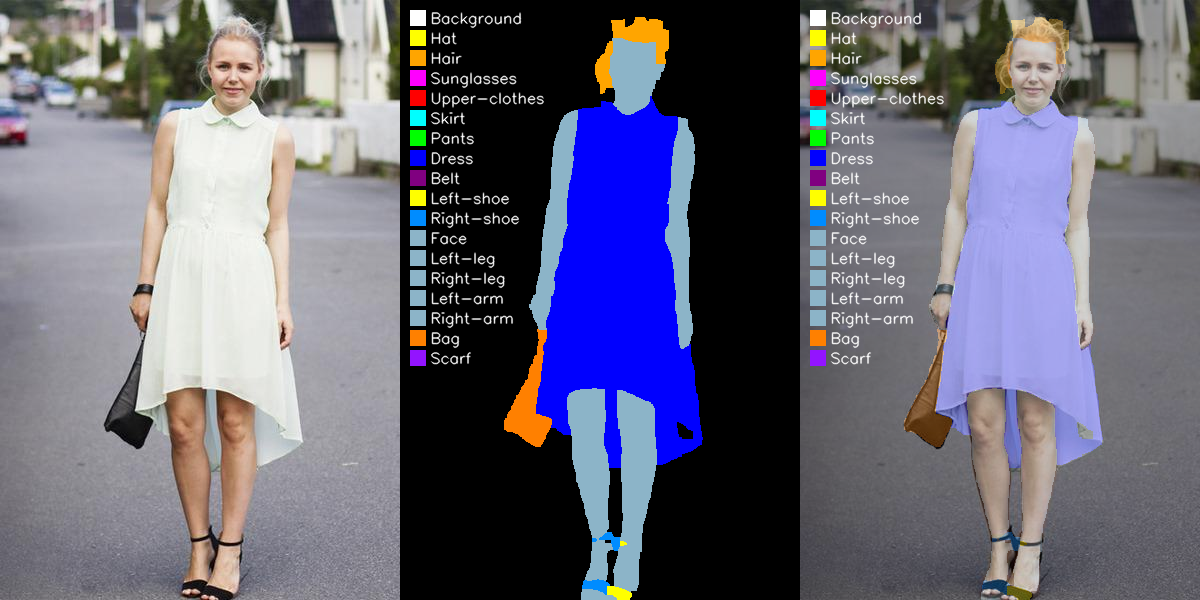

Résultat pour la paire 1 :


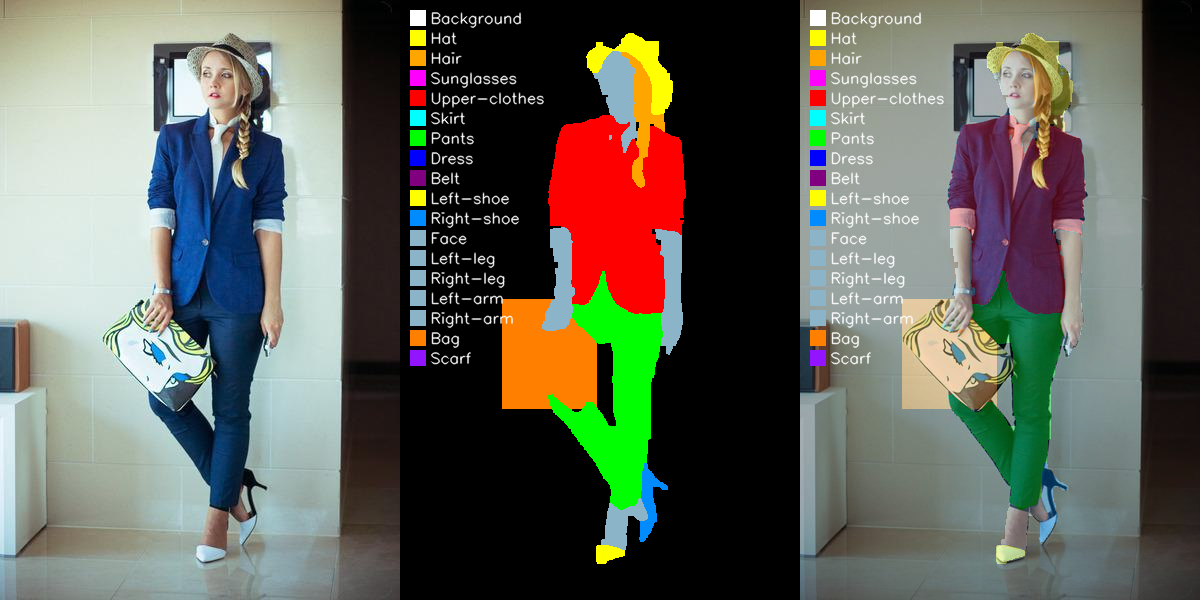

Résultat pour la paire 2 :


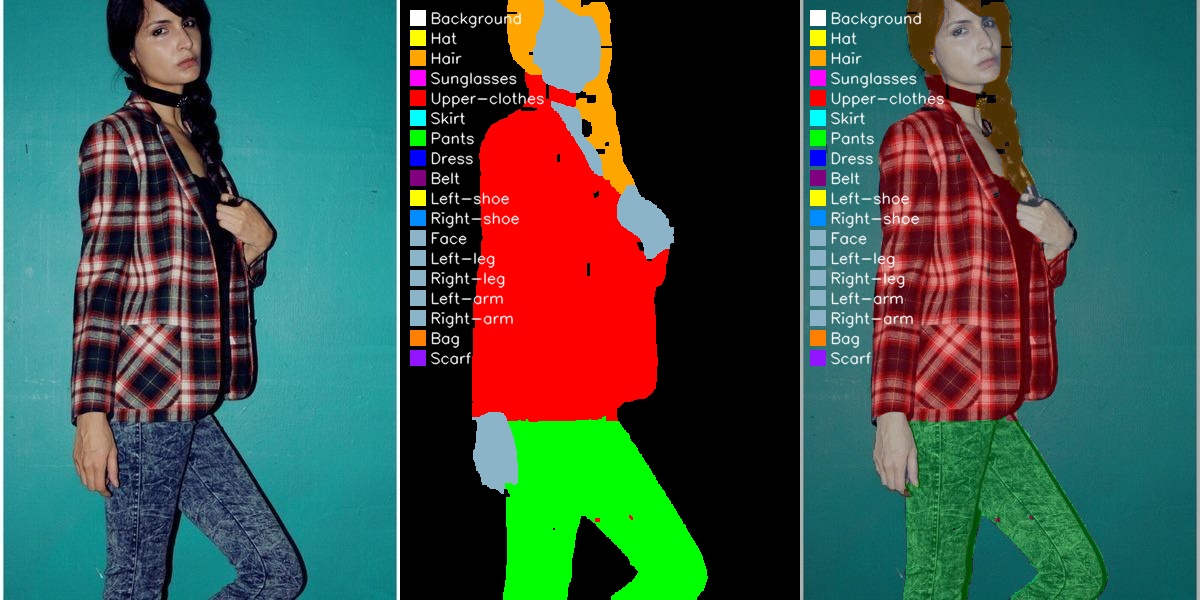

Résultat pour la paire 3 :


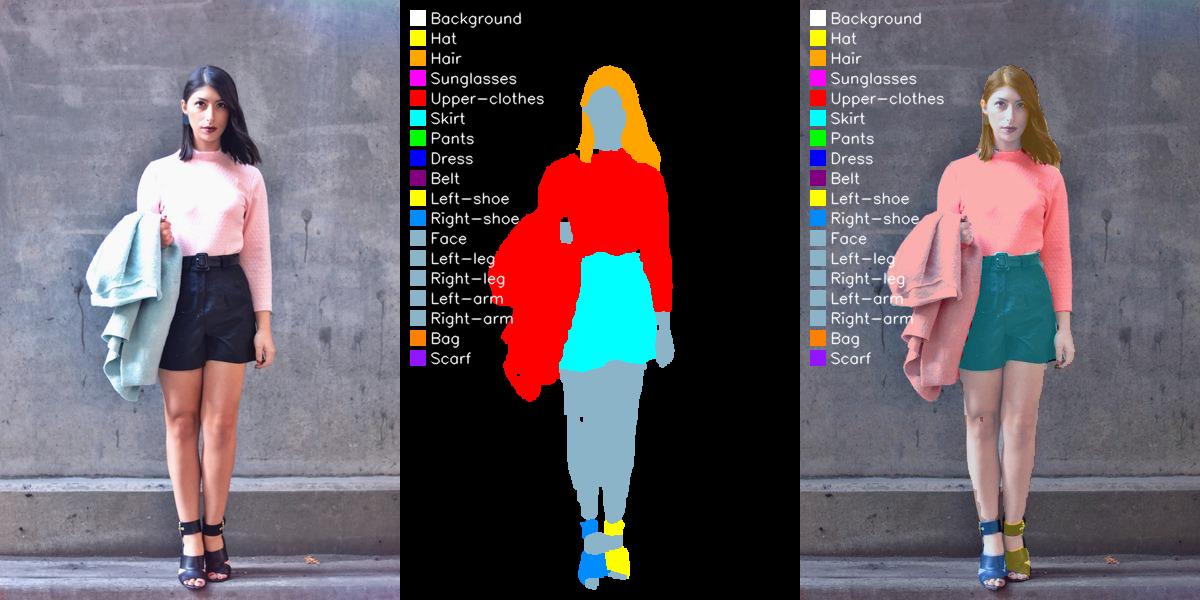

Résultat pour la paire 4 :


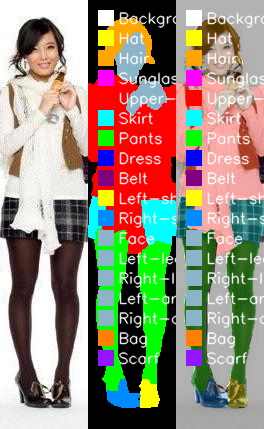

Résultat pour la paire 5 :


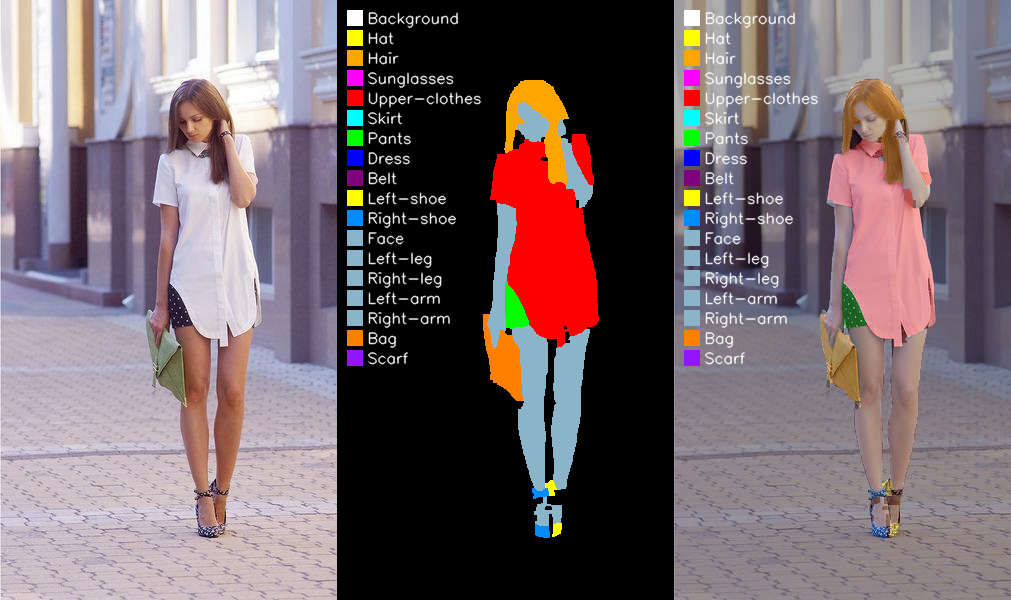

Résultat pour la paire 6 :


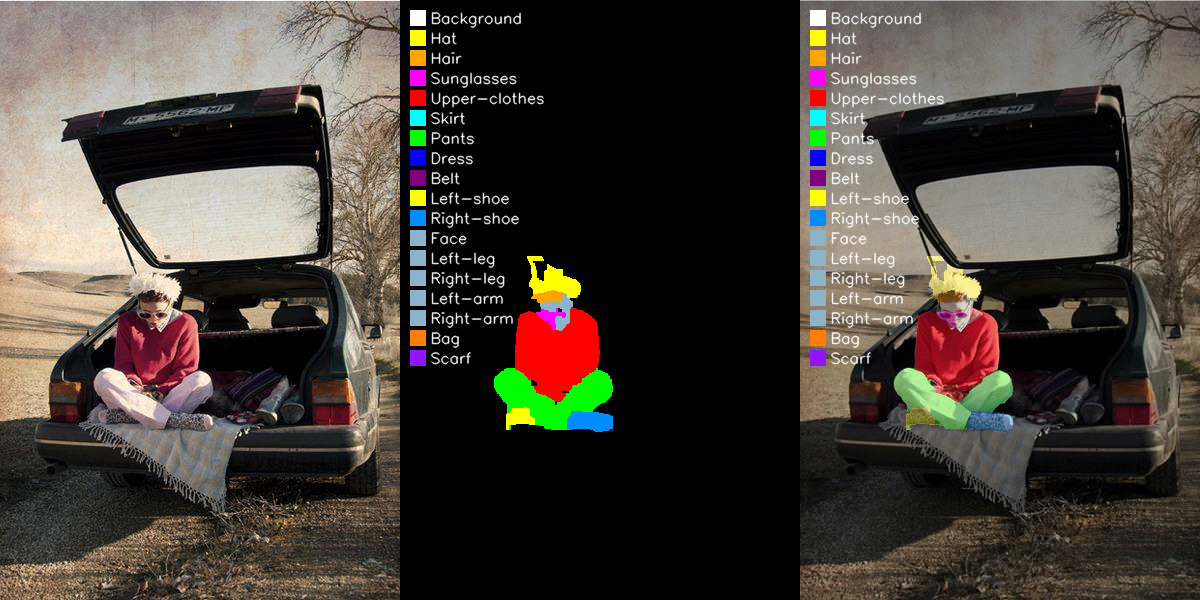

Résultat pour la paire 7 :


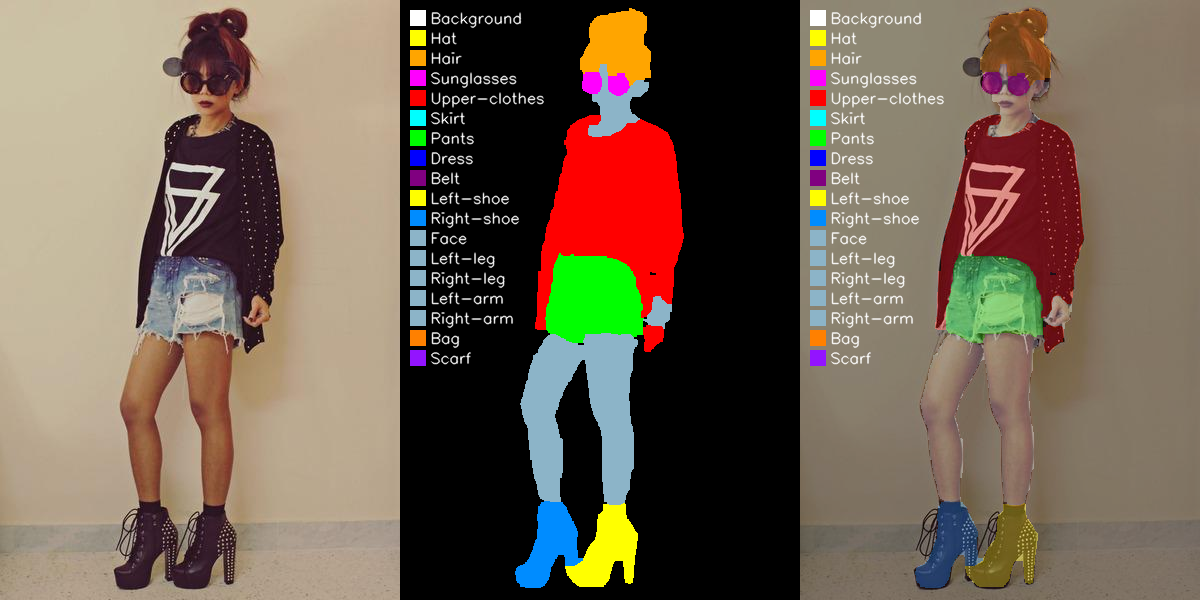

Résultat pour la paire 8 :


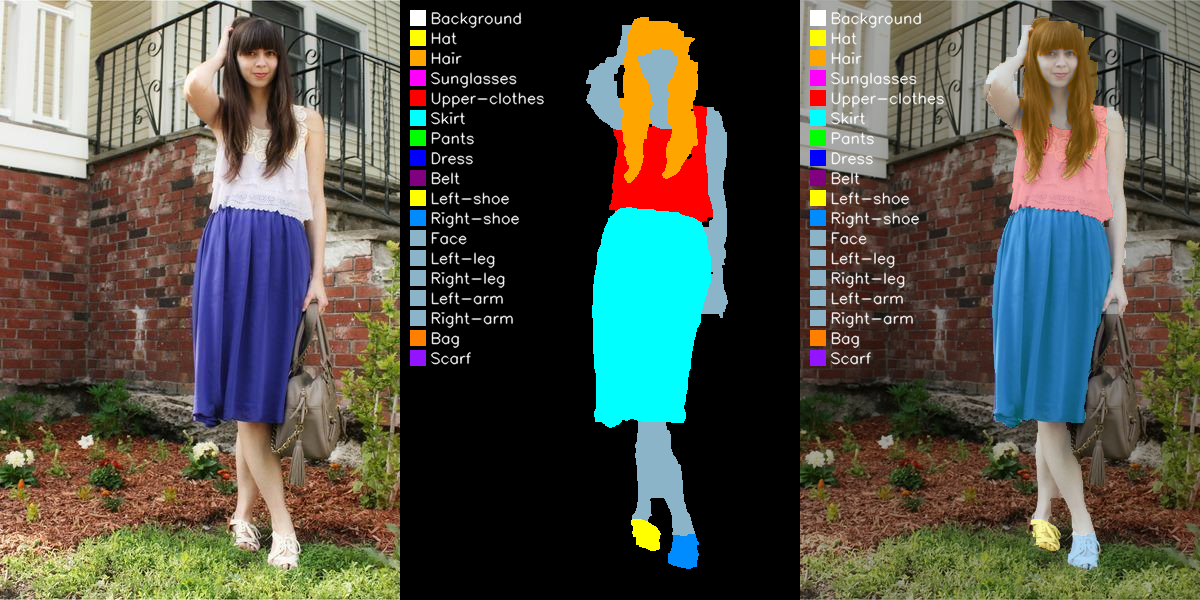

Résultat pour la paire 9 :


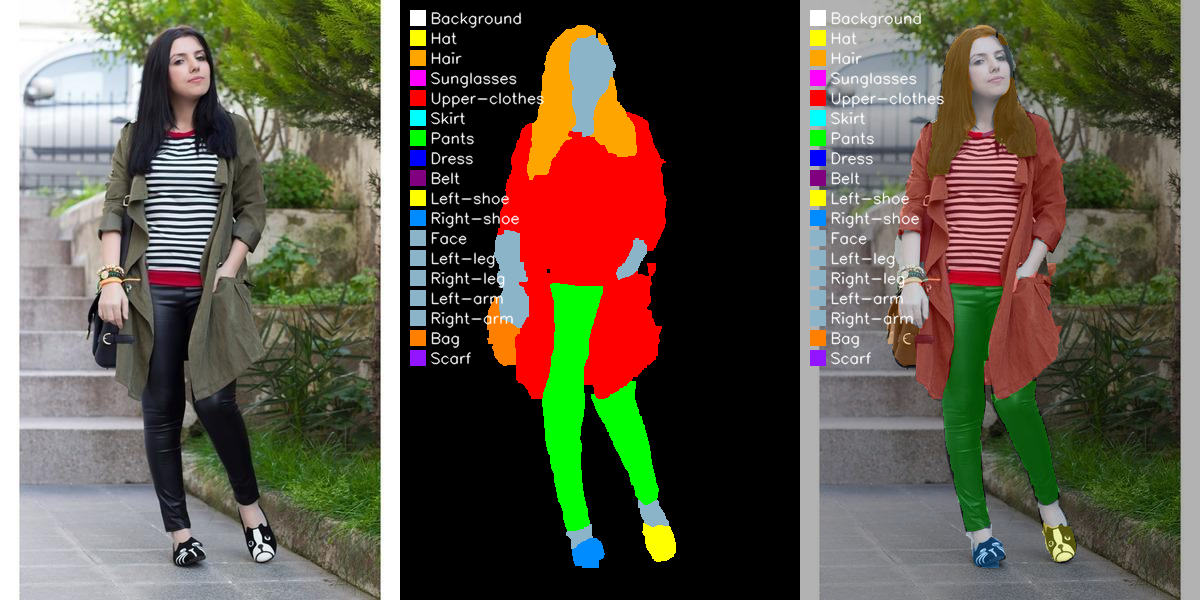

In [1]:
# Installer la bibliothèque datasets
!pip install datasets --quiet

from datasets import load_dataset
import os
import cv2
import numpy as np
import random
from google.colab.patches import cv2_imshow  # Pour l'affichage dans Colab

# 1. Chargement du dataset et enregistrement local

# Chargement du dataset complet (ici, le split "train")
ds = load_dataset("mattmdjaga/human_parsing_dataset", split="train[:100%]", num_proc=8)
print(ds)

# Création des dossiers pour enregistrer les images et les masques
os.makedirs("images", exist_ok=True)
os.makedirs("masks", exist_ok=True)

# Sélection de 3 indices aléatoires parmi les échantillons disponibles
indices = random.sample(range(len(ds)), 10)

for i, idx in enumerate(indices):
    sample = ds[idx]
    image = sample["image"]    # objet PIL.Image
    mask = sample["mask"]      # objet PIL.Image (potentiellement couleur)

    # Conversion en tableaux NumPy
    image_np = np.array(image)
    mask_np = np.array(mask)

    # Si le masque possède 3 canaux, le convertir en niveaux de gris
    if mask_np.ndim == 3:
        mask_np = cv2.cvtColor(mask_np, cv2.COLOR_BGR2GRAY)

    # Conversion de l'image de RGB à BGR (pour cv2.imwrite)
    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    # Sauvegarde de l'image et du masque
    cv2.imwrite(os.path.join("images", f"image_{i}.png"), image_bgr)
    cv2.imwrite(os.path.join("masks", f"mask_{i}.png"), mask_np)

print("Enregistrement des images et masques terminé.")

# 2. Définition d'un colormap personnalisé et lecture des paires

# Colormap personnalisé pour 4 classes (valeurs 1 à 4) en BGR
custom_colormap = {
    1: (0, 255, 255),   # Jaune - Hat
    2: (0, 165, 255),   # Orange - Hair
    3: (255, 0, 255),   # Magenta - Sunglasses
    4: (0, 0, 255),     # Rouge - Upper-clothes
    5: (255, 255, 0),   # Cyan - Skirt
    6: (0, 255, 0),     # Vert - Pants
    7: (255, 0, 0),     # Bleu - Dress
    8: (128, 0, 128),   # Violet - Belt
    9: (0, 255, 255),   # Jaune - Left-shoe
    10: (255, 140, 0),  # Orange foncé - Right-shoe
    11: (200, 180, 140), # Beige - Face
    12: (200, 180, 140), # Beige - Left-leg
    13: (200, 180, 140), # Beige - Right-leg
    14: (200, 180, 140), # Beige - Left-arm
    15: (200, 180, 140), # Beige - Right-arm
    16: (0, 128, 255),  # Bleu clair - Bag
    17: (255, 20, 147)  # Rose - Scarf
}

# Légendes associées aux labels
legend_labels = {
    "0": "Background",
    "1": "Hat",
    "2": "Hair",
    "3": "Sunglasses",
    "4": "Upper-clothes",
    "5": "Skirt",
    "6": "Pants",
    "7": "Dress",
    "8": "Belt",
    "9": "Left-shoe",
    "10": "Right-shoe",
    "11": "Face",
    "12": "Left-leg",
    "13": "Right-leg",
    "14": "Left-arm",
    "15": "Right-arm",
    "16": "Bag",
    "17": "Scarf"
}

# Lecture des paires image/mask depuis les dossiers
image_files = sorted(os.listdir("images"))
mask_files = sorted(os.listdir("masks"))

paires = []
for img_file, mask_file in zip(image_files, mask_files):
    img_path = os.path.join("images", img_file)
    mask_path = os.path.join("masks", mask_file)

    image = cv2.imread(img_path)                       # Image en couleur
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)   # Masque en niveaux de gris

    paires.append((image, mask))

print("Lecture des paires image/mask effectuée.")

# 3. Fonctions pour coloriser le masque et ajouter la légende

def colorize_mask(mask, colormap):
    """
    Applique le colormap personnalisé au masque.
    Pour chaque pixel, s'il correspond à un label défini dans colormap,
    la couleur correspondante est assignée.
    """
    colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for label, color in colormap.items():
        colored_mask[mask == label] = color
    return colored_mask

def add_legend(image, legend, start_x=10, start_y=10, box_size=15, spacing=5):
    """
    Ajoute une légende sur l'image.
    Pour chaque label, dessine un rectangle de la couleur correspondante et le texte associé.
    """
    img_with_legend = image.copy()
    y = start_y
    for label, text in legend.items():
        # Récupération de la couleur du label
        color = custom_colormap.get(int(label), (255, 255, 255))
        # Dessin d'un petit rectangle rempli
        cv2.rectangle(img_with_legend, (start_x, y), (start_x + box_size, y + box_size), color, -1)
        # Ajout du texte à droite du rectangle
        cv2.putText(img_with_legend, text, (start_x + box_size + spacing, y + box_size - 2),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        y += box_size + spacing
    return img_with_legend

# 4. Application du colormap, ajout de la légende et superposition image/mask

for idx, (img, msk) in enumerate(paires):
    # Colorisation du masque avec le colormap personnalisé
    colored_mask = colorize_mask(msk, custom_colormap)

    # Ajout de la légende sur le masque colorisé
    colored_mask_with_legend = add_legend(colored_mask, legend_labels)

    # Superposition du masque coloré sur l'image originale
    overlay = cv2.addWeighted(img, 0.7, colored_mask, 0.3, 0)
    overlay_with_legend = add_legend(overlay, legend_labels)

    # Concatenation des images sur une seule ligne
    concatenated = np.hstack([img, colored_mask_with_legend, overlay_with_legend])

    # Affichage des résultats dans Colab
    print(f"Résultat pour la paire {idx} :")
    cv2_imshow(concatenated)